<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/K_SOA_Toluene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Toluene**

- n=1>>0.34%
- n=2>>3.60%
- n=3>>15.78%
- n=4>>30.02%
- n=5, f=3, cutoff=0.7>>38.77% (20min)
- n=5, f=3, cutoff=0.6>>43.40 (45min)
- n=5, f=3, cutoff=0.5>>44.77%(90min)

- n=1>>0.34%
- n=2>>3.95%
- n=3>>16.98%
- n=4>>31.39%
- n=5, f=3, cutoff=0.7>>38.77% (20min)
- n=5, f=3, cutoff=0.6>>43.40 (45min)
- n=5, f=3, cutoff=0.5>>44.77%(90min)

In [ ]:
!pip install rdkit
!pip install molmass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io
from molmass import Formula
import matplotlib.pyplot as plt
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors

**1. Functions definition**

In [ ]:
def cluster_and_filter(mols, cutoff):
    # 1. Calculate Fingerprints for current molecules
    fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in mols]

    # 2. Calculate distances iteratively
    num_mols = len(mols)
    dists = []
    for i in range(1, num_mols):
        sims = rdkit.DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1 - x for x in sims])  # Convert similarity to distance

    cs = Butina.ClusterData(dists, num_mols, cutoff, isDistData=True)
    unique_mols = [mols[c[0]] for c in cs]
    return unique_mols

# Mass calculation from data
def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        mh_mass = mono_mass - 1.007825  # [M-H]
        mph_mass = mono_mass + 1.007825  # [M+H]
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Trace reaction Function
def trace_reaction_path(target_product_smiles, reaction_history):
    """Traces the reaction pathway through reaction_history"""

    reaction_path = []
    current_product = target_product_smiles

    # Search in reaction_history
    while current_product:
        found_in_history = False
        for i in range(len(reaction_history) - 1, -1, -1):
            if reaction_history[i][2] == current_product:
                reaction_path.insert(0, reaction_history[i])
                current_product = reaction_history[i][0]
                found_in_history = True
                break

        if not found_in_history:
            current_product = None

    return reaction_path

**2. Experimental data with mass calculation**

In [ ]:
# online file
url = "https://docs.google.com/spreadsheets/d/1pBx8tnFjT5FHe-KaPjAOxNMYgYAr6ie-/edit?usp=sharing&ouid=105784435570061437896&rtpof=true&sd=true"

# spreadsheet ID
spreadsheet_id = url.split("/d/")[1].split("/")[0]

# Excel export URL
excel_export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=xlsx"

# Download
response = requests.get(excel_export_url)
response.raise_for_status()

# Read
exp_data = pd.read_excel(io.BytesIO(response.content), sheet_name='Tol_NH3_CHON', engine='openpyxl')

# Add new column for Monoisotopic mass:
exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x))
)

exp_data.head()

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,neutral_mass,pos_mass,Mono_Abund,Total_Abund,Calc_m/z,...,#O,#S,H/C,N/C,O/C,S/C,Osc,Neutral_Mass,[M-H],[M+H]
0,NO4,5.5,5,C7H7NO4,168.030370,169.038195,170.045995,84906561.99,91434808.22,168.030231,...,4,0,1.0000,0.1429,0.5714,0,-0.4286,169.037508,168.029683,170.045333
1,NO4,5.5,5,C6H5NO4,154.014731,155.022556,156.030356,61072644.65,64970660.40,154.014581,...,4,0,0.8333,0.1667,0.6667,0,-0.1666,155.021858,154.014033,156.029683
2,N2O6,6.5,6,C7H6N2O6,213.015519,214.023344,215.031144,15825731.09,17159318.81,213.015309,...,6,0,0.8571,0.2857,0.8571,0,0.0000,214.022586,213.014761,215.030411
3,N2O10,3.5,3,C7H12N2O10,283.042127,284.049952,285.057752,13027120.30,14047110.36,283.041918,...,10,0,1.7143,0.2857,1.4286,0,-0.2857,284.049195,283.041370,285.057020
4,N3O13,3.5,3,C7H13N3O13,346.037477,347.045302,348.053102,9003501.35,9746036.59,346.037561,...,13,0,1.8571,0.4286,1.8571,0,0.0000,347.044837,346.037012,348.052662


**3. Simulation method**

**Step_1**

In [ ]:
reaction_rules = [
    #-----------------------------------------------selected group-----------------------------------------#

    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][OH]'),                           # n=3>>0%-top3(round2),n=1>>0.69%(selected)
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N+](=O)[O-]'),                   # n=3>>1.20%-top3(round2),n=1>>4.63%(selected)
    AllChem.ReactionFromSmarts('[cH:1]>>[c:1][N](=O)'),                        # n=3>>1.20%-top3(round2),n=1>>4.80%(selected)

    AllChem.ReactionFromSmarts('[cH:1]>>[c:1]OO'),                             # n=3>>1.89%-top3(round2),n=1>>5.15%(selected)
    # Toluene to benzaldehyde (Side-chain oxidation)
    AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][C:2]=O'),                  # n=3>>2.23%-top3(round2),n=1>>6.00%(selected)

    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]OO'),                          # n=3>>2.23%-top3(round2),n=1>>7.03%(selected)
    AllChem.ReactionFromSmarts('[cH:1]>>[cH:1][O][N+](=O)[O-]'),               # n=3>>3.43%-top3(round2),n=1>>9.78%(selected)
    #Friedel-Crafts methylation
    AllChem.ReactionFromSmarts('[c:1][cH:2][cH:3]>>[c:1][c:2]([CH3])[cH:3]'),  # n=3>>4.12% -top3(round2),n=1>>10.81%(selected)

    AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]=[C:2][C:3]=[C:4][C:5]=[C:6]'), #n=3>>3.95%(selected)
    AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]=[C:2][C:3]1[C:4][C:5][C:6]1'), #n=3>>4.12%(selected)-top3(round2),n=1>>10.46%
    AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]1[C:2]=[C:3][C:4][C:5][C:6]1'), #n=3>>
    #-----Nitration: NO₂ group addition----#
    AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N+](=O)[O-]'),       #      n=1>>4.12%(selected)
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N+](=O)[O-]'),        #      n=1>>11.84%(selected,sum=11.84%)+

    #-----Nitrosation: NO group addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N](=O)'),             #      n=1>>12.69%(selected,sum=12.69%)+

    #-----Carboxylation: COOH group addition----#
    AllChem.ReactionFromSmarts('[CH3:1]>>[C:1]C(=O)O'),               #      n=1>>15.09%(selected)
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)O'),              #      n=1>>18.01%(selected,sum=18.01%)+

    #-----Carbonylation: CO group addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)'),               #      n=1>>18.35%(selected,sum=18.35%)+

    #-----Amination: NH2 addition----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][NH2]'),                #      n=1>>18.52%(selected,sum=18.52%)+

    #-----Epoxidation / Internal Rearrangement----#
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]C(=O)C[C:2]'),          #    n=1>>18.70%(selected)+

    #-----Oligomerization----#
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH]=[CH][C:2]'),        #    n=1>>19.38%(selected)+

    #Branched dimerization
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1][CH][CH2][C:2]'),          # n=3>>12.18%,selected)

    # ----Addition of NO----#
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][NO]-[C:2]'),            # n=1>>19.55%(selected)+

    # 24.Ozonolysis
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](=O).[C:2](=O)'),            #n=1>>19.73%(selected)+

    #-----Nitrate ester formation----#
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][O][N+](=O)[O-]'),         #n=1>>19.90%(selected,sum=19.90%)+

    # OH radical substitution on methyl
    AllChem.ReactionFromSmarts('[CH3:1]>>[OH:1]'),                             #n=3>>16.98%(selected)

    #--------------------------------------------From MCM web--------------------------------------------------#
    #AllChem.ReactionFromSmarts('Cc1ccccc1>>[O]OCc1ccccc1'),         # Toluene>>C6H5CH2O2(1)        # n=3>>4.12 -top3(round2),n=1>>10.81%-
    AllChem.ReactionFromSmarts('Cc1ccccc1>>[O]OC1C=CC2(C)OOC1C2O'),  # Toluene>>TLBIPERO2(2)        # n=3>>4.12 -top3(round2),n=1>>11.32%(selected)
    #AllChem.ReactionFromSmarts('Cc1ccccc1>>O=CC1OC1C=CC(=O)C'),     # Toluene>>TLEPOXMUC(3)        # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('Cc1ccccc1>>Cc1ccccc1O'),            # Toluene>>CRESOL(4)           # n=3>>4.12 -top3(round2),n=1>>11.32%-

    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>[O]Cc1ccccc1'),      # (1)C6H5CH2O2>>C6H5CH2O         # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>O=N(=O)OCc1ccccc1'), # (1)C6H5CH2O2>>C6H5CH2NO3       # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>OOCc1ccccc1'),       # (1)C6H5CH2O2>>C6H5CH2OOH       # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>O=Cc1ccccc1'),       # (1)C6H5CH2O2>>BENZAL           # n=3>>4.12 -top3(round2),n=1>>11.32%-
    #AllChem.ReactionFromSmarts('[O]OCc1ccccc1>>OCc1ccccc1'),        # (1)C6H5CH2O2>>C6H5CH2OH        # n=3>>4.12 -top3(round2),n=1>>11.32%-

    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>[O]C1C=CC2(C)OOC1C2O'),      # (2)TLBIPERO2>>TLBIPERO     # n=3>>4.12-top3(round2),n=1>>11.32%-
    AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>O=N(=O)OC1C=CC2(C)OOC1C2O'),  # (2)TLBIPERO2>>TLBIPERNO3   # n=3>>4.46-top3(round2),n=1>>13.04%(selected)
    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>OOC1C=CC2(C)OOC1C2O'),       # (2)TLBIPERO2>>TLBIPEROOH  # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>OC1C=CC2(C)OOC1C2O'),        # (2)TLBIPERO2>>TLBIPER2OH   # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('[O]OC1C=CC2(C)OOC1C2O>>O=C1C=CC2(C)OOC1C2O'),       # (2)TLBIPERO2>>TLOBIPEROH   # n=3>>4.46-top3(round2),n=1>>13.04%-

    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>O=CC1OC1C=O.CC(=O)O[O]'),        # (3) TLEPOXMUC>>EPXC4DIAL.CH3CO3   # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>[O]OC(C=O)C=CC(=O)C'),           # (3) TLEPOXMUC>>C615CO2O2          # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>CC(=O)C=CC1OC1C(=O)O[O]'),       # (3) TLEPOXMUC>>TLEMUCCO3          # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>[O]OC(C(=O)C)C(O)C1OC1C=O'),     # (3) TLEPOXMUC>>TLEMUCO2           # n=3>>4.46-top3(round2),n=1>>13.04%-
    #AllChem.ReactionFromSmarts('O=CC1OC1C=CC(=O)C>>O=CC1OC1C=O.[O-][O+]=CC(=O)C'),  # (3) TLEPOXMUC>>EPXC4DIAL.MGLOOB   # n=3>>4.46-top3(round2),n=1>>13.04%-

    #AllChem.ReactionFromSmarts('Cc1ccccc1O>>Cc1ccccc1[O]'),                    # (4)CRESOL>>TOL1O       # n=3>>4.46-top3(round2),n=1>>13.04%-
    AllChem.ReactionFromSmarts('Cc1ccccc1O>>[O]OC1(O)C=CC2(C)OOC1C2O'),         # (4)CRESOL>>CRESO2      # n=3>>4.46-top3(round2),n=1>>13.55%(selected)
    #AllChem.ReactionFromSmarts('Cc1ccccc1O>>Oc1c(C)cccc1O'),                   # (4)CRESOL>>MCATECHOL   # n=3>>4.46-top3(round2),n=1>>13.55%-
    AllChem.ReactionFromSmarts('Cc1ccccc1O>>[O]OC1(O)C=CC2(C)OOC1C2ON(=O)=O'),  # (4)CRESOL>>NCRESO2     # n=3>>4.46-top3(round2),n=1>>14.07%(selected)

    #-----------------------------------Literature------------------------------------------#
    #AllChem.ReactionFromSmarts('CC1=CC=CC=C1>>CC1=C[C]C(O)C=C1'),              # OH radical addition    # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC([N+]([O-])=O)=CC=C1'),   # Nitration              # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC(N=O)=CC=C1'),            # Nitrosation            # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC=CC=C1'),                 # Dehydration            # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=C[C]CC=C1>>CC1=CC(O[O])CC=C1'),            # Peroxidation           # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=CC(C)CC=C1>>CC1=CC([O])CC=C1'),            # Reduction(oxyradical)  # n=3>>4.46-top3(round2),n=1>>14.07%-
    #AllChem.ReactionFromSmarts('CC1=CC(C)CC=C1>>CC1=CC(O[N+]([O-])=O)=CC=C1'), # Nitration              # n=3>>4.46-top3(round2),n=1>>14.07%-

    #AllChem.ReactionFromSmarts('CC1(OO2)C(O)C2C=CC1[O]>>O=C/C=C/C=O.O=CC(C)=O'), #Selfdegradation #n=1>>19.90%-
    #AllChem.ReactionFromSmarts('O=C/C=C/C=O>>O=C(O)/C=C/C(O)=O'),                #Oxidation-      #n=1>>19.90%-
    #AllChem.ReactionFromSmarts('O=C/C=C/C=O>>O=C(N)/C=C/C(N)=O'),                #Amidation-      #n=1>>19.90%-

    # -----------------------------------------Tested rules-------------------------------------------------#
    #AllChem.ReactionFromSmarts('[cH:1]>>[c:1]'),                              # n=3>>0%-top3(round2),n=1>>0%-
    #AllChem.ReactionFromSmarts('[cH:1]>>[c:1][NH2]'),                         # n=3>>1.20%-top3(round2),n=1>>4.80%-
    #AllChem.ReactionFromSmarts('[c:1][CH:2]=O>>[c:1][C:2](=O)[OH]'),          # n=3>>2.23%-top3(round2),n=1>>6.00%-

    #AllChem.ReactionFromSmarts('[c:1][CH2:2][OH]>>[c:1][CHO:2]'),       # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][CH2:2][OH]'),     # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1]OO>>[cH:1][O][NO2]'),             # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1]OO>>[cH:1][O][N+](=O)[O-]'),      # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][C:2](=O)[OH]'),   # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][CH:2]=O'),        # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][CH3:2]>>[cH:1][CH2:2]OO'),       # n=3>>4.12 -top3(round2),n=1>>10.81%-

    #AllChem.ReactionFromSmarts('[c:1][CH2:2][OH]>>[c:1][CH:2]=O'),      # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[cH:1][OH]>>[c:1]=O'),                  # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][NH2]'),        # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[c:1][N](=O)>>[c:1][N][OH]'),           # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH2:2]'),           # n=3>>4.12 -top3(round2),n=1>>10.81%-
    #---------------------------------------------Next step----------------------------------------------------------#
    #-----Nitration: NO₂ group addition----#
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N+](=O)[O-]'),         #     n=1>>4.12%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N+](=O)[O-]'),          #      n=1>>4.12%-

    #-----Nitrosation: NO group addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][N](=O)'),            #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][N](=O)'),              #     n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][N](=O)'),               #      n=1>>3.43%-

    #-----Carboxylation: COOH group addition----#
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]C(=O)O'),               #     n=1>>5.32%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1]C(=O)O'),                #      n=1>>5.66%-

    #-----Carbonylation: CO group addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]C(=O)'),              #      n=1>>5.66%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]C(=O)'),                #     n=1>>4.97%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1]C(=O)'),                 #      n=1>>4.80%-

    #-----Carbon Coupling----#
    #AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1][C:2]'),              #     n=1>>4.29%-

    #-----Hydroperoxide Formation----#
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                  #      n=1>>4.63%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                   #     n=1>>4.63%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]OO'),                   #     n=1>>7.03%-
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]OO'),              #         n=1>>3.43%-

    #-----Amination: NH2 addition----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][NH2]'),               #     n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][NH2]'),                 #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][NH2]'),                 #    n=1>>3.95%-

    #-----Hydroxylation: OH addition----#
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][OH]'),                 #     n=1>>6.35%-
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                #     n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][OH]'),                  #      n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][OH]'),                #      n=1>>3.95%-

    #-----Radical Generation----#
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][*]'),                   #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][*]'),                #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][*]'),                 #      n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][*]'),                   #      n=1>>3.43%-

    #-----Alkene Oxidation/Dihydroxylation----#
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2]'),        #      n=1>>3.60%-
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2](O)'),      #     n=1>>4.29%-

    #-----Carbon Chain Branching----#
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)'),                # (2)  n=1>>5.15%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)[C:2]'),         #      n=1>>3.60%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)'),               #      n=1>>7.38%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)[C:2]'),        #      n=3>>4.63%

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C'),               # (3)  n=1>>3.95%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C[C:2]'),         #     n=1>>3.60%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C'),              #      n=1>>6.17%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C[C:2]'),        #     n=1>>3.95%

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C(C)'),            # (4)  n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C(C)[C:2]'),     #      n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C(=C)'),          #      n=1>>8.23%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C(=C)[C:2]'),    #     n=1>>3.95%

    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(C)C(C)C'),           # (5)  n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)C(C)C[C:2]'),     #     n=1>>3.43%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=C)C(=C)C'),         #      n=1>>5.66
    #AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(=C)C(=C)C[C:2]'),   #     n=1>>3.43%

    #AllChem.ReactionFromSmarts('[C:1](O)[CH3]>>[C:1]=[CH2]'),            # 14.Dehydration                n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](O)C>>[C:1]'),                      # 14.Dehydration                n=1>>3.60%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)>>[C:1](=O)[OH]'),             #                               n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)>>[C:1](=O)[O]'),              #    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH:1](=O)[OH]>>[C:1](=O)[NH2]'),        #    n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](=[O:2])[H]>>[C:1](=[O:2])[OH]'),   #    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1](=O)[NH2]'),         #    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)[O:2]>>[C:1](=O)[N:2]'),        #    n=1>>3.43%-

    #-----Epoxidation / Internal Rearrangement----#
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]OC[C:2]'),             #    n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][NO2]-[C:2]'),         # Addition of NO₂ to alkene            n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[CH2:1]=[CH2:2]>>[C:1](=O)[OH].[C:2](=O)'),  # Criegee intermediate formation   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]1OC1[C:2]>>[C:1][OH][CH2:2][OH]'),      #                                  n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][ONO2]'),                     # Nitrate ester formation          n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[OH:1]>>[O:1][*]'),                      #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[OOH:1]>>[OO:1][*]'),                    #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[OO:1][*]>>[O:1][*]'),                   #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][OH:2]>>[O:1][O:2][*]'),            #TTT                                   n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[O:1][O:2][*]>>[O:1][N+:2](=O)[O-]'),    #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][O][*]>>[O:1][N+](=O)[O-]'),        #TTT                                   n=>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][*]>>[O:1][N+](=O)[O-]'),           #TTT                                   n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[O:1][O][*]>>[O:1][N]=O'),               #TTT                                   n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[O:1][*]>>[O:1][N]=O'),                  #TTT                                   n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[CH:1][OH]>>[C:1]=O'),                   # 23.Oxidation of Alcohol to carbonyl  n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](C[OH])>>[C:1](C=O)'),              # 30.Alcohol Oxidation                 n=1>>4.29%-
    #AllChem.ReactionFromSmarts('[C:1](C=O)>>[C:1](C(=O)O)'),             # 31.Aldehyde to carboxylic acid       n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)OO>>[C:1](=O)O'),               # 33.Peroxy acid to carboxylic acid    n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](O)>>[C:1][NH2]'),                  # 34.Alcohol to amine                  n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N]=O'),                  # 35.Peroxynitrite formation           n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1][O:2][O]>>[C:1][O:2][N]=O'),        # 35.Peroxynitrite formation           n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1][O:2][O][*]>>[C:1][O:2][N]=O'),     #                                      n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N+](=O)[O-]'),           # 36.Peroxynitrite formation             n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1][O][O]>>[C:1][O]'),                 # 37.Hydroperoxide to alcohol(OOH to OH) n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O'),                       # 39.ROO• to to carbonyl                 n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[O]'),                    # 40.ROO• to peracid                     n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](=O)O>>[C:1](=O)[NH2]'),            # 41.Carboxylic acid to amide            n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]C(=O)[O-]>>[C:1]C(=O)[NH2]'),       # 42.Ammonolysis                         n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1]=O>>[C:1]=N[O]'),                   # 45.Oxime-like formation                n=1>>3.43%-

    #AllChem.ReactionFromSmarts('[C:1](=O)[CH3]>>[C:1]=N'),               #n=1>>3.43%-
    #AllChem.ReactionFromSmarts('[C:1](=O)O[*]>>[C:1](=O)[NH2]'),         #n=1>>3.43%-

    #-----Nitrate ester formation----#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][O][N+](=O)[O-]'),       #n=1>>4.80%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][O][N+](=O)[O-]'),        #n=1>>4.80%-
    #AllChem.ReactionFromSmarts('[CH:1]>>[C:1][O][N+](=O)[O-]'),          #n=1>>7.89%-

    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][O][N](=O)'),            #n=1>>4.12%-
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][O][N](=O)'),             #n=1>>4.12%-
    #AllChem.ReactionFromSmarts('[CH:1][*]>>[C:1][O][N](=O)'),            #n=1>>6.86%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][O][N](=O)'),             #n=1>>7.03%-

    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]([OH])[C:2][*]'),      # OH addition #n=1>>3.95%-
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]O[O*]'),                  # O2 addition #n=1>>7.03%-
    #AllChem.ReactionFromSmarts('[C:1]O[O*]>> [C:1]O'),                   # NO reaction #n=1>>3.43%-

    #-------------------Others---------------------#
    #AllChem.ReactionFromSmarts('[C:1]OO[*:2]>>[C:1]OO[C:2]'),             # n=1>>19.90%-
    #AllChem.ReactionFromSmarts('[c:1]OO[*:2]>>[c:1]OO[c:2]'),             # n=3>>4.46-top3(round2),n=1>>14.07%-

    #----------------------------OTHER------------------------------#
    # Aromatic hydroxylation (to cresol-like structure)
    #AllChem.ReactionFromSmarts('[cH:1]>>[c:1][OH]'),  # aromatic C-H → C-OH    #n=3>>-

    # Epoxidation of double bond (on ring-opened structures)
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]1[O][C:2]1'),                #n=3>>-

    # Diol formation on ring-opened alkenes
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1][OH].[C:2][OH]'),            #n=3>>-

    # Aldehyde formation from benzylic alcohol
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1]=O'),                       #n=3>>-

    # Aldehyde to acid
    #AllChem.ReactionFromSmarts('[CH:1]=O>>[C:1](=O)[OH]'),                     #n=3>>-

    # Peracid formation (R–COOOH)
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1](=O)OO'),                  #n=3>>-

    # NO2 reduction to NO
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[N](=O)'),                       #n=3>>-

    # NO oxidation to NO2
    #AllChem.ReactionFromSmarts('[N](=O)>>[N+](=O)[O-]'),                       #n=3>>-

    # Decarboxylation
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1]'),                        #n=3>>-

    # Carboxylic acid + OH → dihydroxybenzene (oxidized)
    #AllChem.ReactionFromSmarts('[c:1](C(=O)O)>>[c:1][OH]'),                    #n=3>>-

    # Alkyl side chain hydroxylation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                        #n=3>>-

    # Ketone from methyl oxidation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[C:1](=O)[CH3]'),                     #n=3>>-

    # Addition of OOH radical
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1]OO'),                           #n=3>>-

    # Nitro group to hydroxylamine (partial reduction)
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[N:1][OH]'),                     #n=3>>-

    # OH-induced ring cleavage at ortho-dihydroxybenzene
    #AllChem.ReactionFromSmarts('Oc1ccc(O)cc1>>O=C1C=CC(=O)C=C1'),              #n=3>>-

    # OH radical substitution on benzylic CH2
    #AllChem.ReactionFromSmarts('[CH2:1][c:2]>>[CH:1]([OH])[c:2]'),             #n=3>>-

    # Nitro group conversion to amine (reduction)
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[NH2]'),                         #n=3>>-

    # NO2 substitution with OH
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][OH]'),                #n=3>>-

    # NO2 substitution with H (denitration)
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[cH:1]'),                   #n=3>>-

    # Ring cleavage to two aldehydes
    #AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[CH:1]=O.[CH:2]=O.[CH:3]=O'),  #n=3>>-

    # OH attack on alkyl side chain → hydroxyalkyl
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                        #n=3>>-

    # Methyl to COOH through oxidation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[C:1](=O)[OH]'),                      #n=3>>-

    # Alkyl chain cracking
    #AllChem.ReactionFromSmarts('[CH3:1][CH2:2]>>[CH3:1].[CH2:2]'),             #n=3>>-

    # Benzene ring with methyl group oxidized to formyl (CHO)
    #AllChem.ReactionFromSmarts('[CH3:1][c:2]>>[CH:1]=O.[c:2]'),                #n=3>>-

    # NO2 to hydroxylamine (deep reduction)
    #AllChem.ReactionFromSmarts('[N+](=O)[O-]>>[NH][OH]'),                      #n=3>>-

    # Benzyl alcohol to benzoic acid
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[C:1](=O)[OH]'),                  #n=3>>-

    # Alkene epoxidation (applies to ring-opened structures)
    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1]1[O][C:2]1'),                #n=3>>-

    # Allylic oxidation (C=C–CH3 to C=C–CH2OH)
    #AllChem.ReactionFromSmarts('[CH3:1][C:2]=[C:3]>>[CH2:1]([OH])[C:2]=[C:3]'), #n=3>>-

    # Ether formation on benzylic alcohol
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH2:1][O][CH3]'),                #n=3>>-

    # Benzylic oxidation sequence
    #AllChem.ReactionFromSmarts('[c:1][CH2:2][OH]>>[c:1][CHO:2]'),              # benzyl alcohol to aldehyde    #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][CHO:2]>>[c:1][C:2](=O)OO'),              # aldehyde to peroxyacid        #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][C:2](=O)OO>>[c:1][C:2](=O)[OH]'),        # peroxyacid to carboxylic acid #n=3>>-

    # Ring-opening to dicarbonyls (low volatility products)
    #AllChem.ReactionFromSmarts('[c:1]([OH])[c:2]([OH])>>[CHO:1][CH2][CH2][CHO:2]'),  # ring opening to dicarbonyl
    #AllChem.ReactionFromSmarts('[c:1]1[c:2]([OH])[c:3][c:4][c:5][c:6]1>>[C:1]=[C:2][C:3]=[C:4][C:5]=[C:6]'), # OH-assisted ring opening

    # Nitro compound transformations
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][NH2]'),               # nitro reduction      #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][N+](=O)[O-]>>[c:1][NO2][OH]'),           # nitro + OH           #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][N](=O)>>[c:1][NH][OH]'),                 # nitroso + OH         #n=3>>-

    # Heterocyclic formation
    #AllChem.ReactionFromSmarts('[c:1][CHO:2]>>[c:1][C:2]1[NH][C][C][O]1'),      # furan formation       #n=3>>-
    #AllChem.ReactionFromSmarts('[c:1][C:2](=O)[OH]>>[c:1][C:2]1[O][C][C][O]1'), # lactone formation     #n=3>>-

    #------------------ Radical Oxidation / Hydroxylation ------------------#
    #AllChem.ReactionFromSmarts('[CH2:1][c:2]>>[CH:1]([OH])[c:2]'),             # Benzylic hydroxylation
    #AllChem.ReactionFromSmarts('[CH3:1][CH2:2]>>[CH3:1][CH:2][OH]'),           # Secondary alcohol formation
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1][OH]'),                        # Primary C hydroxylation
    #AllChem.ReactionFromSmarts('[c:1][CH3:2]>>[c:1][CH2:2][OH]'),              # Benzyl OH via OH radical

    #------------------ Ketone/Aldehyde/Oxidative Progression ------------------#
    #AllChem.ReactionFromSmarts('[CH:1]([OH])[c:2]>>[C:1](=O)[c:2]'),           # Alcohol to ketone
    #AllChem.ReactionFromSmarts('[CH:1]=O>>[C:1](=O)[OH]'),                     # Aldehyde to carboxylic acid
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1]=O'),                       # Alcohol to aldehyde

    #------------------ NO, NO2, NO3 Chemistry ------------------#
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][NO]'),                         # Nitrosation
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][NO2]'),                        # Nitration
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][ONO2]'),                       # Nitrate ester
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1][ONO]'),                       # Nitrite ester
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1][NO2]'),                       # Direct OH → NO2 substitution

    #------------------ ROOH / Peroxy Intermediates ------------------#
    #AllChem.ReactionFromSmarts('[CH3:1]>>[CH2:1]OO'),                         # Hydroperoxide formation
    #AllChem.ReactionFromSmarts('[CH2:1]OO>>[CH2:1]OO'),                       # Peroxy to hydroperoxide
    #AllChem.ReactionFromSmarts('[CH2:1]OO>>[CH:1]=O'),                        # ROOH cleavage to aldehyde
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]=O'),                           # General ROOH to carbonyl

    #------------------ Ring Opening & Fragmentation ------------------#
    #AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[CH:1]=[CH:2][CH:3]=[CH:4][CH:5]=[CH:6]'),
    #AllChem.ReactionFromSmarts('[c:1][c:2]>>[CH:1]=O.[CH:2]=O'),              # Aromatic fragmentation → dialdehydes
    #AllChem.ReactionFromSmarts('[c:1][c:2]>>[CH2:1][CH2:2]'),                 # Saturation post-fragmentation

    #------------------ Carboxylate Chain Formation ------------------#
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1][COOH]'),                  # Alcohol → carboxylic acid
    #AllChem.ReactionFromSmarts('[CH2:1]>>[CH:1][COOH]'),                      # Direct CH2 oxidation

    #------------------ Amination & Functionalization ------------------#
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][NH2]'),                          # Primary amination
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH2:1][NH2]'),                     # OH to NH2
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1][NH][OH]'),                      # Hydroxylamine formation
    #AllChem.ReactionFromSmarts('[C:1][NH2]>>[C:1]N(=O)'),                        # Amination to nitroso

    #------------------ Decarboxylation & Fragment Loss ------------------#
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[CH3:1]'),                       # COOH to CH3 (decarboxylation)
    #AllChem.ReactionFromSmarts('[C:1](=O)[OH]>>[C:1][H]'),                      # Acid to hydrogen radical

    #------------------ Misc Substitutions ------------------#
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][OCH3]'),                        # Methoxylation
    #AllChem.ReactionFromSmarts('[C:1][H]>>[C:1][OCH2CH3]'),                     # Ethoxylation

    #------------------ Secondary Transformations ------------------#
    #AllChem.ReactionFromSmarts('[CH:1](=O)[CH3]>>[C:1]([OH])[CH3]'),              # Ketone → alcohol
    #AllChem.ReactionFromSmarts('[CH2:1][CH2:2]>>[CH:1]=[CH:2]'),                # Alkyl → alkene
    #AllChem.ReactionFromSmarts('[CH2:1][OH]>>[CH:1]=[O]'),                      # Alcohol → aldehyde

    #------------------ Meta-cleavage-like fragmentation ------------------#
    #AllChem.ReactionFromSmarts('[c:1]1[c:2][c:3][c:4][c:5][c:6]1>>[C:1]=O.[C:2]=C([COOH])[C:3]=O'),  # Muconic acid analog
]

In [ ]:
###--------Simulation part---------###
chemical_space = {'Cc1ccccc1'}
num_iterations = 3

# Comparison conditions
tolerance = 0.0000001  # 0.1ppm

excel_mw_neg = exp_data['[M-H]'].tolist()
excel_mw_neu = exp_data['Neutral_Mass'].tolist()
excel_mw_pos = exp_data['[M+H]'].tolist()

# Initial conditions
max_mass = exp_data['[M+H]'].max()
max_carbons = exp_data['#C'].max()
max_nitrogens = exp_data['#N'].max()
max_oxygens = exp_data['#O'].max()

# Reaction for chemical_space_1
reaction_history = []
all_matching_smiles = set()
clustering_frequency = 5

for iteration in range(num_iterations):
    temp_new_products = set()
    for reactant_smiles in chemical_space.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            # Valence check
                            prod_mol = Chem.MolFromSmiles(prod_smiles,sanitize=False)
                            if prod_mol is not None and prod_mol.GetNumAtoms() > 0:
                              try:
                                Chem.rdmolops.SanitizeMol(prod_mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
                              except:
                                pass

                              if len(Chem.DetectChemistryProblems(prod_mol)) == 0:

                                # Check and add to temp_new_products and reaction_history
                                if prod_smiles not in chemical_space:
                                    temp_new_products.add(prod_smiles)
                                    # Check if the product is a match and update is_match
                                    is_match = False
                                    calculated_mw_temp = Descriptors.ExactMolWt(prod_mol)

                                    for excel_mw_list, excel_column in zip(
                                    [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']):
                                        for excel_mw_value in excel_mw_list:
                                            diff = abs(calculated_mw_temp - excel_mw_value)
                                            if diff <= tolerance:
                                                is_match = True
                                                break
                                        if is_match:
                                            break

                                    reaction_history.append((reactant_smiles, rxn_index, prod_smiles, is_match))

                        except:
                            pass

    chemical_space.update(temp_new_products)
    ###----------Periodic clustering and filtering-------###
    #if (iteration + 1) % clustering_frequency == 0:
        #temp_mols = [Chem.MolFromSmiles(smi) for smi in chemical_space]
        #fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in temp_mols]
        #unique_products = cluster_and_filter(temp_mols, cutoff=0.6)
        #chemical_space = set([Chem.MolToSmiles(mol) for mol in unique_products])
    ##########################################################

# Apply threshold based on experimental data limits
chemical_space_1 = {smi for smi in chemical_space
                           if Chem.MolFromSmiles(smi) is not None and
                           Descriptors.ExactMolWt(Chem.MolFromSmiles(smi)) <= max_mass
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 6) <= max_carbons
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 7) <= max_nitrogens
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 8) <= max_oxygens}

# Create mols_1 and valid_smiles_1
mols_1 = [Chem.MolFromSmiles(smi) for smi in chemical_space if Chem.MolFromSmiles(smi) is not None]
valid_smiles_1 = [smi for smi in chemical_space if Chem.MolFromSmiles(smi) is not None]


[14:32:12] reactant 0 has no mapped atoms.
[14:32:12] product 0 has no mapped atoms.
[14:32:12] reactant 0 has no mapped atoms.
[14:32:12] product 0 has no mapped atoms.
[14:32:12] reactant 0 has no mapped atoms.
[14:32:12] product 0 has no mapped atoms.
[14:32:12] reactant 0 has no mapped atoms.
[14:32:12] product 0 has no mapped atoms.


**Matching Comparison and Filtering**

In [ ]:
# **Matching Comparison and Filtering**

all_matching_smiles_initial = set() # Temporary set
matching_smiles_by_excel_row_initial = {} # Temporary dictionary

for smi in valid_smiles_1:
    calculated_mw_value = Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance:
                all_matching_smiles_initial.add(smi)
                row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
                if row_index not in matching_smiles_by_excel_row_initial:
                    matching_smiles_by_excel_row_initial[row_index] = []
                if smi not in matching_smiles_by_excel_row_initial[row_index]:
                    matching_smiles_by_excel_row_initial[row_index].append(smi)
                break
        # Move to the next simulated molecule if it matched any Excel value
        if smi in all_matching_smiles_initial:
            break

print(f"Number of initial matching smiles found: {len(all_matching_smiles_initial)}")

Number of initial matching smiles found: 3864


In [ ]:
# **Filtering Unrealistic Products**

all_matching_smiles = set()
removed_unrealistic_count = 0

# Filtering criteria
allowed_elements = {'C', 'H', 'O', 'N'}
allowed_charges = {0, 1, -1} # allow neutral, +1, and -1 charges

print("Filtering unrealistic products from matching smiles...")

for smi in all_matching_smiles_initial:
    mol = Chem.MolFromSmiles(smi)

    if mol is None:
        removed_unrealistic_count += 1
        continue

    # 1. Valence Check
    problems = Chem.DetectChemistryProblems(mol)
    if len(problems) > 0:
        removed_unrealistic_count += 1
        continue

    # 2. Allowed Atom Types Check
    unallowed_elements = {atom.GetSymbol() for atom in mol.GetAtoms()} - allowed_elements
    if unallowed_elements:
        removed_unrealistic_count += 1
        continue

    # 3. Formal Charge Check
    total_charge = Chem.GetFormalCharge(mol)
    if total_charge not in allowed_charges:
         removed_unrealistic_count += 1
         continue

    # 4. Sanitization Check (Can be repeated here for extra caution)
    mol_sanitized = Chem.MolFromSmiles(smi, sanitize=False)
    if mol_sanitized is not None:
        try:
            Chem.SanitizeMol(mol_sanitized, Chem.SanitizeFlags.SANITIZE_ALL)
        except Exception as e:
            print(f"Removing {smi} due to sanitization failure: {e}")
            removed_unrealistic_count += 1
            continue

     #If the molecule passes all checks, add it to the final filtered set
    all_matching_smiles.add(smi)

print(f"Number of unrealistic products removed: {removed_unrealistic_count}")
print(f"Number of matching smiles after filtering: {len(all_matching_smiles)}")
print("-" * 20)

# --- Update matching_smiles_by_excel_row based on the filtered smiles ---
matching_smiles_by_excel_row = {}

for row_index, smiles_list in matching_smiles_by_excel_row_initial.items():
    filtered_smiles_for_row = [smi for smi in smiles_list if smi in all_matching_smiles]
    if filtered_smiles_for_row:
        matching_smiles_by_excel_row[row_index] = filtered_smiles_for_row

print(f"Number of Excel rows with matching filtered products: {len(matching_smiles_by_excel_row)}")
print("-" * 20)

Filtering unrealistic products from matching smiles...
Number of unrealistic products removed: 0
Number of matching smiles after filtering: 3864
--------------------
Number of Excel rows with matching filtered products: 99
--------------------


In [ ]:
# **Final Matching Percentage**

matching_excel_info_all = list(matching_smiles_by_excel_row.keys())

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

matching_indices_set = set(matching_excel_info_all)
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Final matching percentage: {matching_percentage:.4f}%")

Final matching percentage: 16.9811%


In [ ]:
len(chemical_space)

38262

In [ ]:
matching_excel_info_all.sort()
print(matching_excel_info_all)

[0, 1, 2, 6, 15, 16, 20, 21, 27, 30, 32, 37, 39, 40, 42, 52, 55, 58, 64, 65, 70, 79, 90, 91, 102, 114, 117, 126, 127, 130, 139, 140, 144, 148, 150, 151, 161, 165, 169, 173, 186, 188, 193, 199, 208, 210, 214, 215, 233, 234, 235, 237, 239, 248, 276, 280, 290, 295, 305, 318, 323, 330, 335, 361, 363, 366, 370, 373, 378, 379, 380, 383, 386, 387, 389, 395, 400, 403, 404, 410, 446, 451, 461, 462, 465, 471, 491, 508, 512, 521, 525, 533, 538, 553, 556, 564, 570, 573, 575]


In [ ]:
len(k)

NameError: name 'k' is not defined

**5. Pathways**

 Enter the number of pathways you want to show:5
For matching product found in Excel row index: 0
SMILES: C=C(C=CC=C[N+](=O)[O-])C(=O)O
Reaction pathway:


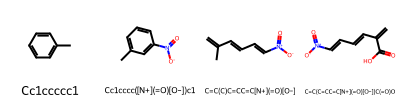

--------------------
For matching product found in Excel row index: 1
SMILES: O=Nc1c(O)cccc1OO
Reaction pathway:


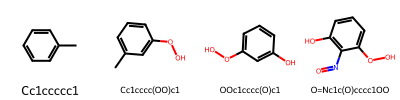

--------------------
For matching product found in Excel row index: 2
SMILES: Cc1cc(N=O)c(OO)c(O[N+](=O)[O-])c1
Reaction pathway:


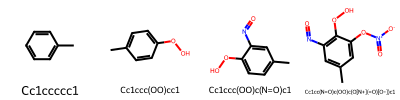

--------------------
For matching product found in Excel row index: 6
SMILES: CC12C=CC(O)(N=O)C(OO1)C2O[N+](=O)[O-]
Reaction pathway:


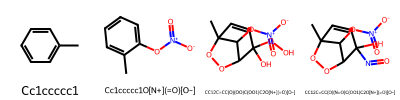

--------------------
For matching product found in Excel row index: 15
SMILES: O=NC12C=CC(O[N+](=O)[O-])C(OO1)C2O
Reaction pathway:


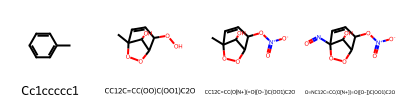

--------------------


In [ ]:
# Get the unique Excel row indices
unique_matching_excel_indices = list(matching_smiles_by_excel_row.keys())

# Sort the unique Excel row indices
unique_matching_excel_indices.sort()

# Number of pathways to trace
num_pathways_to_trace = int(input(" Enter the number of pathways you want to show:"))

# Iterate through the unique matching Excel row indices
for i in range(min(num_pathways_to_trace, len(unique_matching_excel_indices))):
    excel_row_index = unique_matching_excel_indices[i]
    matching_smiles_for_row = matching_smiles_by_excel_row.get(excel_row_index, [])

    # Choose order of one matching smiles for this row (e.g., the first one in the list)
    if matching_smiles_for_row:
        product_smiles_to_trace = matching_smiles_for_row[0]

        print(f"For matching product found in Excel row index: {excel_row_index}")
        print(f"SMILES: {product_smiles_to_trace}")

        pathway = trace_reaction_path(product_smiles_to_trace, reaction_history)

        if pathway:
            print(f"Reaction pathway:")

            # Collect molecules
            pathway_molecules = []
            legends = []

            # Add the initial reactant if valid
            initial_reactant_smi = pathway[0][0] if pathway else None
            if initial_reactant_smi and Chem.MolFromSmiles(initial_reactant_smi) is not None:
                 pathway_molecules.append(Chem.MolFromSmiles(initial_reactant_smi))
                 legends.append(initial_reactant_smi)

            for step in pathway:
                reactant, rxn_index, product, is_match = step
                product_mol = Chem.MolFromSmiles(product)

                # Check if the product molecule is valid and not already added
                if product_mol is not None:
                    # Check if the molecule object is already in the list by comparing SMILES
                    if product not in legends: # Compare against legends (SMILES strings)
                         pathway_molecules.append(product_mol)
                         legends.append(product)


            # Only draw if there are molecules to display
            if pathway_molecules:
                img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                           subImgSize=(100, 100), legends=legends, useSVG=True)

                display(img)
            print("-" * 20)
        else:
             print(f"No pathway found for {product_smiles_to_trace}")
             print("-" * 20)
    else:
        print(f"No matching simulated smiles found for Excel row index: {excel_row_index}")
        print("-" * 20)

**The pathway for a specific row with their list index**

Select the specific matching row:2
Found 121 matching simulated product(s) for this row.
Matching SMILES:
  [0] Cc1cc(N=O)c(OO)c(O[N+](=O)[O-])c1
  [1] Cc1c(O)ccc(O[N+](=O)[O-])c1[N+](=O)[O-]
  [2] O=[N+]([O-])Cc1ccc(OO)c([N+](=O)[O-])c1
  [3] Cc1ccc(O[N+](=O)[O-])cc1O[N+](=O)[O-]
  [4] Cc1cc(OO)c([N+](=O)[O-])cc1[N+](=O)[O-]
  [5] Cc1cc([N+](=O)[O-])c(O)cc1O[N+](=O)[O-]
  [6] Cc1cc(O[N+](=O)[O-])c([N+](=O)[O-])cc1O
  [7] Cc1ccc(O[N+](=O)[O-])c([N+](=O)[O-])c1O
  [8] O=[N+]([O-])c1cccc([N+](=O)[O-])c1COO
  [9] Cc1cc(O[N+](=O)[O-])c(O)c([N+](=O)[O-])c1
  [10] Cc1ccc([N+](=O)[O-])c([N+](=O)[O-])c1OO
  [11] Cc1ccc(O[N+](=O)[O-])c(N=O)c1OO
  [12] Cc1cc(O[N+](=O)[O-])cc(OO)c1N=O
  [13] O=[N+]([O-])Cc1ccc(O)c(O[N+](=O)[O-])c1
  [14] Cc1cc(OO)c(O[N+](=O)[O-])cc1N=O
  [15] Cc1c(O[N+](=O)[O-])ccc(OO)c1N=O
  [16] Cc1c(N=O)ccc(OO)c1O[N+](=O)[O-]
  [17] Cc1ccc(O[N+](=O)[O-])c(O)c1[N+](=O)[O-]
  [18] Cc1cccc(O[N+](=O)[O-])c1O[N+](=O)[O-]
  [19] O=[N+]([O-])c1cc(COO)cc([N+](=O)[O-])c1
  [20] O=[N+](

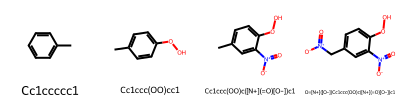

In [ ]:
# **The pathway for a specific row with their list index**
specific_excel_row_index = int(input('Select the specific matching row:'))

if specific_excel_row_index in unique_matching_excel_indices:
    matching_smiles_for_row = matching_smiles_by_excel_row.get(specific_excel_row_index, [])

    if matching_smiles_for_row:
        print(f"Found {len(matching_smiles_for_row)} matching simulated product(s) for this row.")
        print("Matching SMILES:")
        for idx, smi in enumerate(matching_smiles_for_row):
            print(f"  [{idx}] {smi}")

        # Choose which matching smiles index to trace
        smiles_index_input = input(f"The index of the matching SMILES to trace (0 to {len(matching_smiles_for_row) - 1}): ")

        try:
            smiles_index_to_trace = int(smiles_index_input)

            # Check if the chosen index is valid
            if 0 <= smiles_index_to_trace < len(matching_smiles_for_row):
                product_smiles_to_trace = matching_smiles_for_row[smiles_index_to_trace]

                print(f"SMILES selected for tracing: {product_smiles_to_trace}")

                # Trace the reaction pathway
                pathway = trace_reaction_path(product_smiles_to_trace, reaction_history)

                # Check if a pathway was found
                if pathway:
                    print(f"Reaction pathway:")

                    # Collect molecules and legends for visualization
                    pathway_molecules = []
                    legends = []

                    # Add the initial reactant
                    initial_reactant_smi = pathway[0][0] if pathway else None
                    if initial_reactant_smi and Chem.MolFromSmiles(initial_reactant_smi) is not None:
                         pathway_molecules.append(Chem.MolFromSmiles(initial_reactant_smi))
                         legends.append(initial_reactant_smi)
                         print(f"Step 0: Initial reactant: {initial_reactant_smi}")


                    # Add each product molecule in the traced pathway
                    for i, step in enumerate(pathway):
                        reactant, rxn_index, product, is_match = step
                        product_mol = Chem.MolFromSmiles(product)

                        # Check if the product molecule is valid and not already added
                        if product_mol is not None:
                            if product not in legends:
                                 pathway_molecules.append(Chem.MolFromSmiles(product))
                                 legends.append(product)
                                 # Print the reaction rule index
                                 print(f"Step {i+1}: Reactant: {reactant}, Reaction Rule Index: {rxn_index}, Product: {product}")


                    # Display the collected pathway
                    if pathway_molecules:
                        img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                                   subImgSize=(100, 100), legends=legends, useSVG=True)
                        display(img)

                else:
                     print(f"No pathway found for product {product_smiles_to_trace}")

            else:
                 print(f"Error. Please enter an index between 0 and {len(matching_smiles_for_row) - 1}.")

        except ValueError:
             print("Error. Please enter a number.")

    else:
         print(f"Error: No matching simulated smiles found for Excel row index: {specific_excel_row_index}")

else:
    print(f"Error: The entered Excel row index {specific_excel_row_index} did not have any matching simulated products.")
    print("Choose an index from the list of available indices.")

Enter the SMILES string of the molecule to trace the pathway for: O=[N+]([O-])Cc1ccc(OO)c([N+](=O)[O-])c1
Tracing pathway for canonical SMILES: O=[N+]([O-])Cc1ccc(OO)c([N+](=O)[O-])c1
Reaction pathway found:
Step 0: Initial reactant: Cc1ccccc1
Step 1: Reactant: Cc1ccccc1, Reaction Rule Index: 3, Product: Cc1ccc(OO)cc1
Step 2: Reactant: Cc1ccc(OO)cc1, Reaction Rule Index: 1, Product: Cc1ccc(OO)c([N+](=O)[O-])c1
Step 3: Reactant: Cc1ccc(OO)c([N+](=O)[O-])c1, Reaction Rule Index: 10, Product: O=[N+]([O-])Cc1ccc(OO)c([N+](=O)[O-])c1


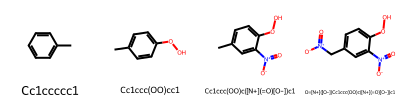

In [ ]:
## Display Pathway for a Specific SMILES

# Prompt the user to enter the SMILES string they want to trace
specific_smiles_to_trace = input("Enter the SMILES string of the molecule to trace the pathway for: ")

# Attempt to convert the entered SMILES to an RDKit molecule to validate it
mol_to_trace = Chem.MolFromSmiles(specific_smiles_to_trace)

if mol_to_trace is not None:
    # If the SMILES is valid, normalize it to canonical SMILES for consistent tracing
    specific_smiles_to_trace_canonical = Chem.MolToSmiles(mol_to_trace, canonical=True)
    print(f"Tracing pathway for canonical SMILES: {specific_smiles_to_trace_canonical}")

    # Trace the reaction pathway using the function defined earlier
    pathway = trace_reaction_path(specific_smiles_to_trace_canonical, reaction_history)

    # Check if a pathway was successfully found in the reaction history
    if pathway:
        print(f"Reaction pathway found:")

        # Lists to store the molecules and their labels (SMILES) for visualization
        pathway_molecules = []
        legends = []

        # The first element of the pathway should be the initial reactant
        initial_reactant_smi = pathway[0][0] if pathway else None

        # Add the initial reactant to the lists if it's valid
        if initial_reactant_smi and Chem.MolFromSmiles(initial_reactant_smi) is not None:
            initial_reactant_mol = Chem.MolFromSmiles(initial_reactant_smi)
            pathway_molecules.append(initial_reactant_mol)
            legends.append(initial_reactant_smi)
            print(f"Step 0: Initial reactant: {initial_reactant_smi}")

        # Iterate through the steps in the traced pathway
        for i, step in enumerate(pathway):
            reactant, rxn_index, product, is_match = step
            product_mol = Chem.MolFromSmiles(product)

            # if the product molecule is valid and has not already been added to the list
            if product_mol is not None:
                 # Check if the canonical SMILES of the product
                 if product not in legends:
                     pathway_molecules.append(product_mol)
                     legends.append(product)
                     # Print the reaction step details
                     print(f"Step {i+1}: Reactant: {reactant}, Reaction Rule Index: {rxn_index}, Product: {product}")


        # Display molecules
        if pathway_molecules:
            img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                       subImgSize=(100, 100), legends=legends, useSVG=True)
            display(img)

    else:
        print(f"No pathway found in the reaction history for the molecule with SMILES: {specific_smiles_to_trace_canonical}")

else:
    print(f"Error: The entered string '{specific_smiles_to_trace}' is not a valid SMILES string.")

In [ ]:
# --- Display molecules matching a specific Excel row ---

# Specify the index of the Excel row
excel_row_index_to_display = int(input("Enter the row index you want to display all molecules"))

# Get the list of matching SMILES for this row
smiles_for_this_row = matching_smiles_by_excel_row.get(excel_row_index_to_display, [])

if smiles_for_this_row:
    print(f"Displaying molecules matching Excel row index: {excel_row_index_to_display}")
    print(f"Found {len(smiles_for_this_row)} matching simulated product(s) for this row.")
    mols_to_draw = [Chem.MolFromSmiles(smi) for smi in smiles_for_this_row if Chem.MolFromSmiles(smi) is not None]
    legends_to_draw = [smi for smi in smiles_for_this_row if Chem.MolFromSmiles(smi) is not None]

    # Draw if there are valid molecules
    if mols_to_draw:
        img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=4, subImgSize=(100, 100),
                                 legends=legends_to_draw,
                                 maxMols=len(mols_to_draw), useSVG=True)
        display(img)
    else:
        print("No valid molecules found for this row after filtering.")
else:
    print(f"No matching molecules found for Excel row index: {excel_row_index_to_display}")

Enter the row index you want to display all molecules2
Displaying molecules matching Excel row index: 2
Found 121 matching simulated product(s) for this row.
